In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTest import *
from backtest.regression_portfolio import *

from factor_mining.Mark0 import * # This is alpha file

In [2]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/' # You will have to change this to the directory of univ.pkl
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v4.csv'
    univ = univ_setup(big_table_dir)
    # filt_by_name(univ) # This is slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

filt_na(univ)
import warnings
warnings.filterwarnings("ignore")

### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])
print('Done')

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Setup R3000 universe
use existing binary file
0.424617 seconds
Calculate factors
Filt the untradables
Done
Scale each factor
Winsorize with +/- 3 std
Done


In [3]:
start = time()
start_date = datetime(2016, 12, 1)
end_date = datetime(2016, 12, 31)
factor_names = list(factors.keys())
spcalc = RegressionPtflSpcalc(all_factor_names=factor_names)
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
ptfl_lst, pnl_lst = bt.calc_pnl(silent=False, has_short=True)
end = time()

print(end - start)

2016-12-02 00:00:00
2016-12-09 00:00:00
2016-12-16 00:00:00
2016-12-23 00:00:00
2016-12-30 00:00:00
45.281129360198975


In [4]:
bt.calc_pa(silent=False)

CAGR :	 1.27565824682
Volatility :	 0.470534172574
Sharpe :	 1.74752312954
Max_Drawdown :	 0.0431835213213
Drawdown_Length :	 0


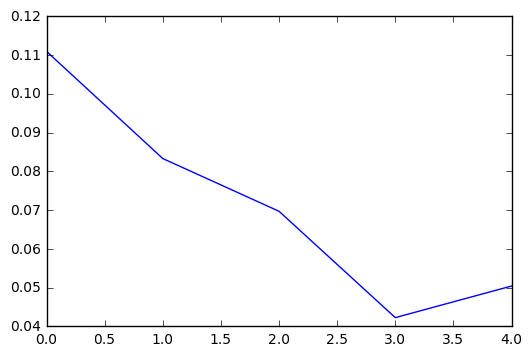

In [5]:
plt.plot(np.cumsum(pnl_lst))
plt.show()

In [6]:
bt.pnl_lst.to_csv('output/pnl_final_pre.csv')